In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow import keras

import seaborn as sns
import matplotlib as mp
%matplotlib inline
import math
import numpy as np
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range


import matplotlib.pyplot as plt
import sklearn.metrics

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


"""this is important because i realized the model might not reset"""
tf.keras.backend.clear_session()

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)

TensorFlow version:  2.1.0


# Table of contents
1. [Baseline Model](#model1)
2. [Adding Layers](#model2)
3. [Adding Convolutions](#model3)
3. [Model Comparison](#compare)

Random seed for reproduction of results

In [12]:
np.random.seed(7)

Load and prep of dataset

In [13]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x2_train = x_train[..., tf.newaxis]
x2_test = x_test[..., tf.newaxis]

Batch and shuffle

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((x2_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x2_test, y_test)).batch(32)

class_names = ['0', '1', '2', '3', '4', 
    '5', '6', '7', '8', '9']

print("Shape: ", x_train[0].shape)
print("Label: ", y_train[0], "->", class_names[y_train[0]])

Shape:  (28, 28)
Label:  5 -> 5


In [18]:
img = np.reshape(x_train[0], (-1, 28, 28, 1))

In [19]:
!rm -rf logs

# Creates a file writer for the log directory. I made it so that different categories contain different stuf
logdir = "logs/sample_data/"
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
    images = np.reshape(x_train[0:25], (-1, 28, 28, 1))
    tf.summary.image("25 training data examples", images, max_outputs=25, step=0)

Visualization of input images

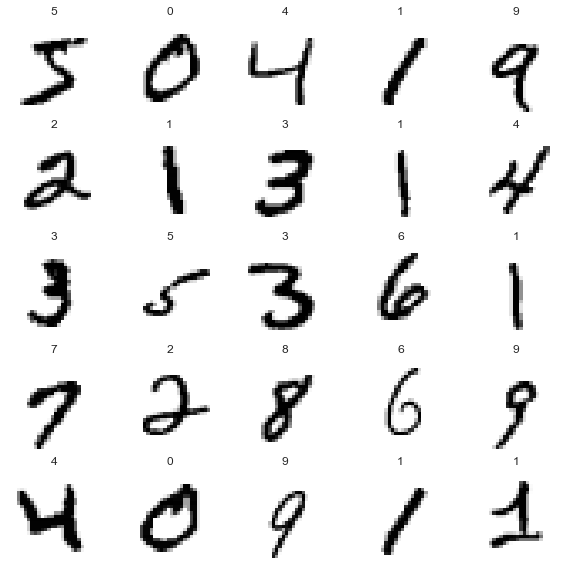

<Figure size 1008x360 with 0 Axes>

In [23]:
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def image_grid():
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
    # Start next subplot.
        plt.subplot(5, 5, i + 1, title=class_names[y_train[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.show()
    return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
    tf.summary.image("Training data", plot_to_image(figure), step=0)

# Baseline Model <a name="introduction"></a>
* Flattening Layer
* Dense Layer 1   w/ RELU activation
* Dropout Layer 1 w/ 30% dropout rate
* Dense Layer 2   w/ RELU activation

Using model subclassing to build model

In [29]:
class ModelBaseline(Model):
    def __init__(self):
        super(ModelBaseline, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        return self.d2(x)

model=ModelBaseline()

Loss function and Optimizer selection

In [30]:
# It uses crossentropy between the labels and predictions to compute loss.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

Error metric selection

In [31]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Model training using gradient tape

In [32]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

Test function

In [33]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [34]:
!rm -rf logs/gradient_tape

In [35]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [39]:
EPOCHS = 10

In [38]:
train_loss_results_baseline = []
train_accuracy_results_baseline = []
test_loss_results_baseline = []
test_accuracy_results_baseline = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_baseline.append(train_loss.result())
    train_accuracy_results_baseline.append(train_acc.result() * 100)
    test_loss_results_baseline.append(test_loss.result())
    test_accuracy_results_baseline.append(test_acc.result() * 100)

Epoch 1, Loss: 0.19163209199905396, Accuracy: 94.19499969482422, Test Loss: 0.12073525041341782, Test Accuracy: 95.48833465576172
Epoch 2, Loss: 0.18231908977031708, Accuracy: 94.4383316040039, Test Loss: 0.11667484045028687, Test Accuracy: 95.65428161621094
Epoch 3, Loss: 0.17291119694709778, Accuracy: 94.6883316040039, Test Loss: 0.11831538379192352, Test Accuracy: 95.7562484741211
Epoch 4, Loss: 0.17138990759849548, Accuracy: 94.71666717529297, Test Loss: 0.11755482852458954, Test Accuracy: 95.84222412109375
Epoch 5, Loss: 0.16507524251937866, Accuracy: 95.0, Test Loss: 0.11227881163358688, Test Accuracy: 95.9489974975586
Epoch 6, Loss: 0.15928342938423157, Accuracy: 95.02166748046875, Test Loss: 0.11081461608409882, Test Accuracy: 96.03545379638672
Epoch 7, Loss: 0.15695445239543915, Accuracy: 95.13166809082031, Test Loss: 0.11080753803253174, Test Accuracy: 96.09249877929688
Epoch 8, Loss: 0.14943480491638184, Accuracy: 95.36666870117188, Test Loss: 0.11475945264101028, Test Accur

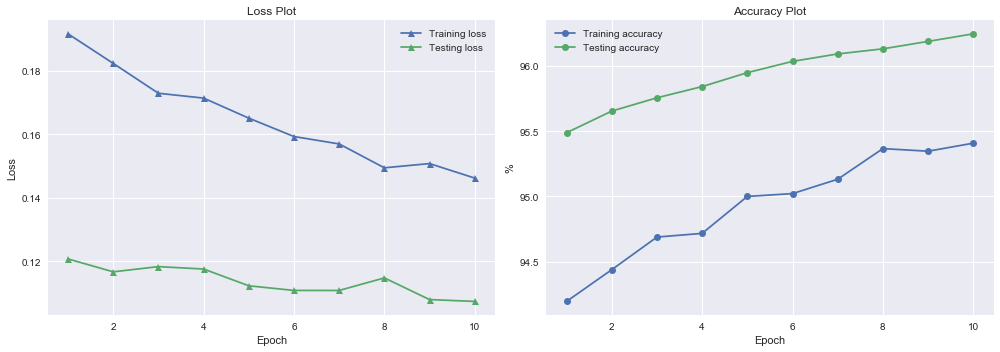

In [69]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_baseline, label='Training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_baseline, label='Testing loss', marker='^')
ax1.set_title("Loss Plot")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_baseline, label='Training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_baseline, label='Testing accuracy', marker='o')
ax2.set_title("Accuracy Plot")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [42]:
model.summary()

Model: "model_baseline_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  35325     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  1610      
Total params: 36,935
Trainable params: 36,935
Non-trainable params: 0
_________________________________________________________________


# Adding Layers <a name="model2"></a>
* Flattening Layer
* Dense Layer 1   w/ RELU activation
* Dropout Layer 1 w/ 30% dropout rate
* Dense Layer 2   w/ RELU activation
* Dense Layer 3   w/ RELU activation
* Dense Layer 4   w/ Softmax activation

In [43]:
class ModelDenser(Model):
    def __init__(self):
        super(ModelDenser, self).__init__()
        self.flat = Flatten()
        self.d1 = Dense(45, activation='relu')
        self.drop = Dropout(0.3)
        self.d2 = Dense(35, activation='relu')
        self.d3 = Dense(23, activation='relu')
        self.d4 = Dense(10, activation='softmax')
    def call(self, x):
        x = self.flat(x)
        x = self.d1(x)
        x = self.drop(x)
        x = self.d2(x)
        x = self.d3(x)
        return self.d4(x)

model=ModelDenser()

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [45]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [46]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [47]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [48]:
!rm -rf logs/gradient_tape

In [49]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [50]:
EPOCHS = 10

In [51]:
train_loss_results_denser = []
train_accuracy_results_denser = []
test_loss_results_denser = []
test_accuracy_results_denser = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_denser.append(train_loss.result())
    train_accuracy_results_denser.append(train_acc.result() * 100)
    test_loss_results_denser.append(test_loss.result())
    test_accuracy_results_denser.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.6831130981445312, Accuracy: 78.8699951171875, Test Loss: 1.5395435094833374, Test Accuracy: 92.36000061035156
Epoch 2, Loss: 1.5608997344970703, Accuracy: 90.413330078125, Test Loss: 1.5251365900039673, Test Accuracy: 93.03500366210938
Epoch 3, Loss: 1.5479997396469116, Accuracy: 91.51166534423828, Test Loss: 1.5185104608535767, Test Accuracy: 93.5233383178711
Epoch 4, Loss: 1.5397316217422485, Accuracy: 92.24166870117188, Test Loss: 1.512916088104248, Test Accuracy: 93.86499786376953
E

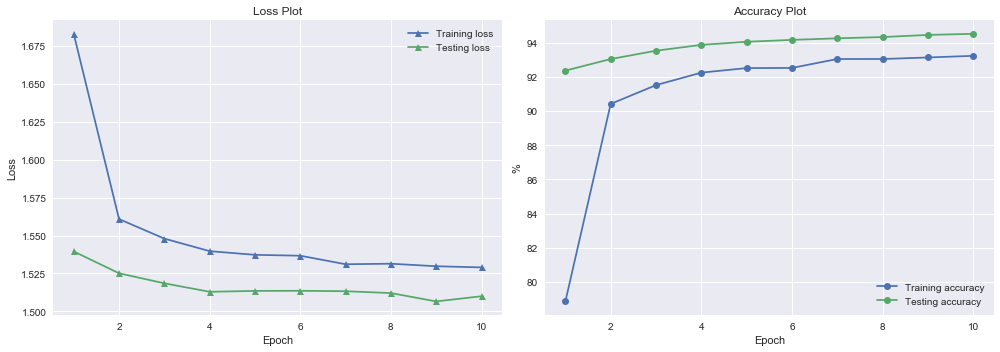

In [67]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_denser, label='Training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_denser, label='Testing loss', marker='^')
ax1.set_title("Loss Plot")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_denser, label='Training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_denser, label='Testing accuracy', marker='o')
ax2.set_title("Accuracy Plot")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [53]:
model.summary()

Model: "model_denser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  35325     
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  1610      
_________________________________________________________________
dense_8 (Dense)              multiple                  828       
_________________________________________________________________
dense_9 (Dense)              multiple                  240       
Total params: 38,003
Trainable params: 38,003
Non-trainable params: 0
__________________________________________________

# Adding Convolutions <a name="model3"></a>
* Convolutional Layer w/ RELU activation
* Flattening Layer
* Dense Layer 1 w/ RELU activation
* Dense Layer 2 w/ Linear activation

In [54]:
class ModelConv(Model):
    def __init__(self):
        super(ModelConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model=ModelConv()

In [55]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [57]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, predictions)

In [58]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_acc(labels, predictions)

In [59]:
!rm -rf logs/gradient_tape

In [60]:
train_log_dir = 'logs/gradient_tape/third_model/train'
test_log_dir = 'logs/gradient_tape/third_model/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [61]:
EPOCHS = 10

In [62]:
train_loss_results_conv = []
train_accuracy_results_conv = []
test_loss_results_conv = []
test_accuracy_results_conv = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    train_acc.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_acc.result(), step=epoch)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_acc.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
    train_loss_results_conv.append(train_loss.result())
    train_accuracy_results_conv.append(train_acc.result() * 100)
    test_loss_results_conv.append(test_loss.result())
    test_accuracy_results_conv.append(test_acc.result() * 100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.1325659453868866, Accuracy: 96.05833435058594, Test Loss: 0.066538006067276, Test Accuracy: 97.79999542236328
Epoch 2, Loss: 0.040567781776189804, Accuracy: 98.7699966430664, Test Loss: 0.05778786167502403, Test Accuracy: 97.95500183105469
Epoch 3, Loss: 0.0213897917419672, Accuracy: 99.30166625976562, Test Loss: 0.06128213554620743, Test Accuracy: 98.03333282470703
Epoch 4, Loss: 0.012942439876496792, Accuracy: 99.5633316040039, Test Loss: 0.06801231950521469, Test Accuracy: 98.1149978

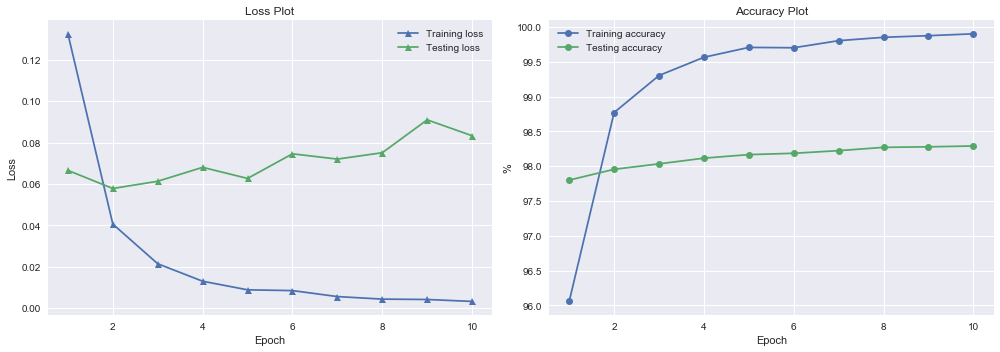

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results_conv, label='Training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_conv, label='Testing loss', marker='^')
ax1.set_title("Loss Plot")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results_conv, label='Training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_conv, label='Testing accuracy', marker='o')
ax2.set_title("Accuracy Plot")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()

In [64]:
model.summary()

Model: "model_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  2769024   
_________________________________________________________________
dense_11 (Dense)             multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


# Model Comparison <a name="compare"></a>

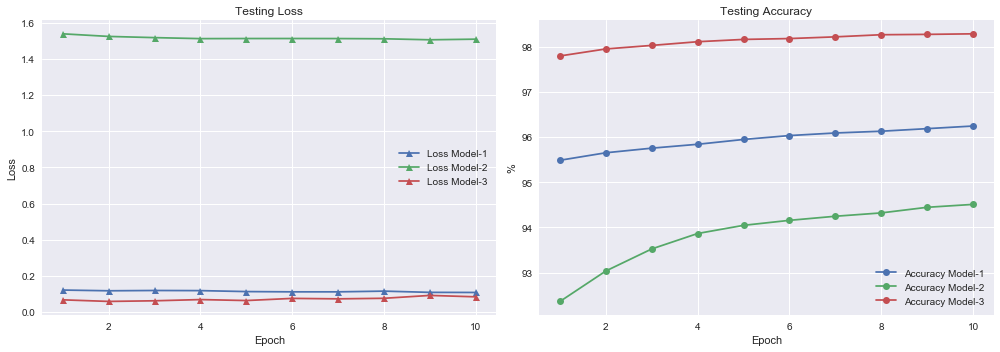

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_baseline, label='Loss Model-1', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_denser, label='Loss Model-2', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results_conv, label='Loss Model-3', marker='^')
ax1.set_title("Testing Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_baseline, label='Accuracy Model-1', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_denser, label='Accuracy Model-2', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results_conv, label='Accuracy Model-3', marker='o')
ax2.set_title("Testing Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("%")
ax1.legend()
ax2.legend()
fig.tight_layout()